<a href="https://colab.research.google.com/github/yohanesnuwara/volve-machine-learning/blob/main/notebook/demo_volve_soniclog_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Demo on P-Sonic Log Prediction using Machine Learning in the Volve Field Dataset

See the complete notebook [here](https://github.com/yohanesnuwara/volve-machine-learning/blob/main/notebook/volve_p_sonic_prediction_final.ipynb). In this shortened workflow, it assumes that we have previously done data prepro.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/yohanesnuwara/volve-machine-learning

Cloning into 'volve-machine-learning'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 101 (delta 47), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (101/101), 13.39 MiB | 3.76 MiB/s, done.
Resolving deltas: 100% (47/47), done.


Load the data for training. This training data contains 3 wells; 11A, 1A, and 1B

In [34]:
# Load training data
well_train = pd.read_csv('/content/volve-machine-learning/results/wells_for_training_demo.csv')
well_train.head(10)

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
1,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
2,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
3,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
4,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4
5,0.266,2.253,51.895,1.214,5.151,8.523,97.171,15_9-F-11A,2600.5
6,0.273,2.244,45.764,1.317,5.205,8.531,95.441,15_9-F-11A,2600.6
7,0.282,2.243,40.914,1.299,5.380,8.523,93.204,15_9-F-11A,2600.7
8,0.290,2.249,40.059,1.186,5.602,8.557,92.143,15_9-F-11A,2600.8
9,0.303,2.258,41.143,1.077,5.829,8.563,92.043,15_9-F-11A,2600.9


We plot the pairplots using `seaborn` as the first EDA.

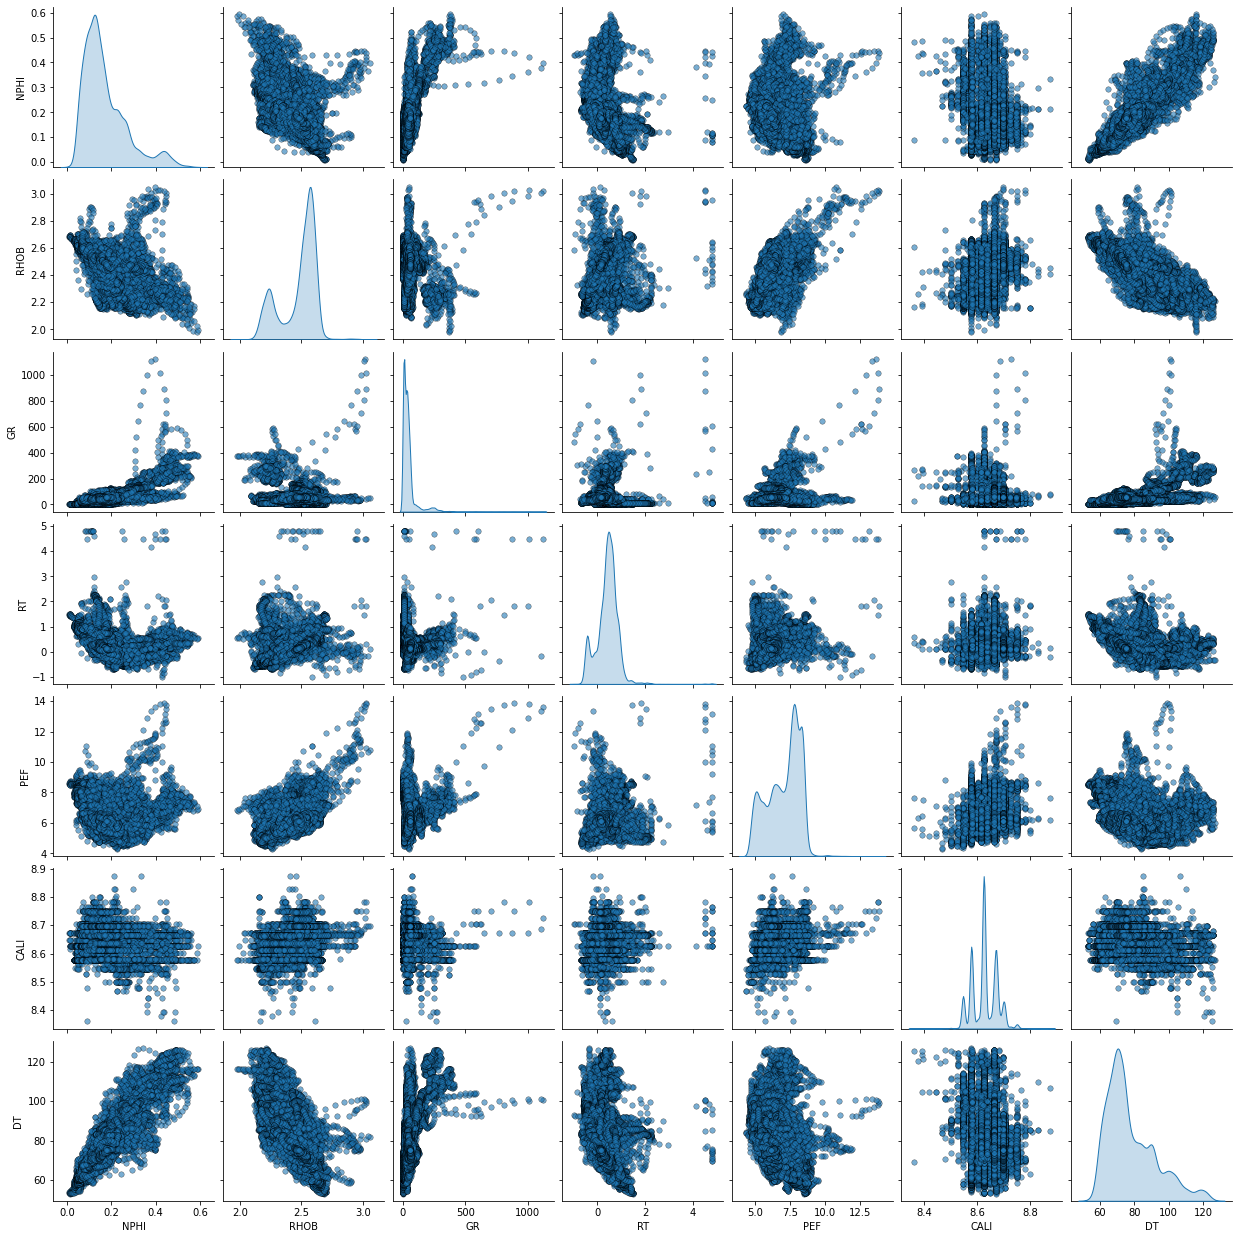

In [47]:
feature_target = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

sns.pairplot(well_train, vars=feature_target, diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

We plot the correlation heatmap as the second EDA.

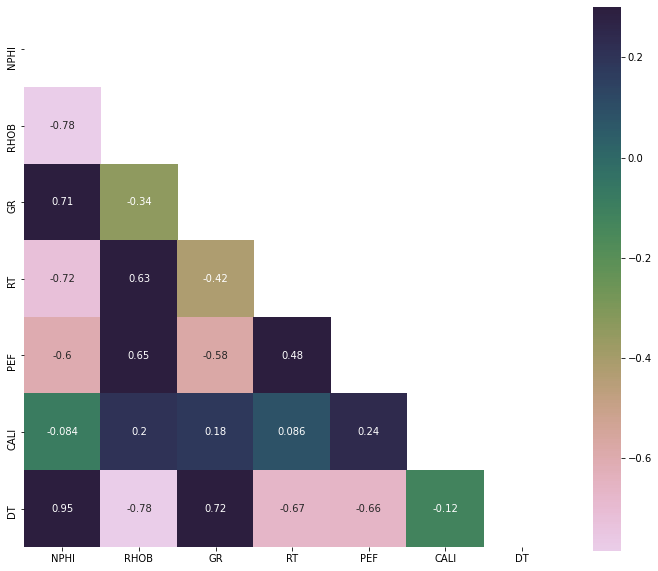

In [49]:
well_train_only_features = well_train[feature_target]

# Generate a mask for the upper triangle
mask = np.zeros_like(well_train_only_features.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,10))
sns.heatmap(well_train_only_features.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=.3, square=True)

plt.show()

Now we do normalization. The best method that we will use is the power transform using Yeo-Johnson method. 

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# transform the RT to logarithmic
well_train['RT'] = np.log10(well_train['RT'])

# normalize using power transform Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# columns
colnames = well_train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

## ColumnTransformer
column_drop = ['WELL', 'DEPTH']
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

## fit and transform
well_train_norm = ct.fit_transform(well_train)

## convert to dataframe
well_train_norm = pd.DataFrame(well_train_norm, columns=colnames)

## up until this step, if we pass df.dtypes, we can see all the results are object. 
## So, we change the dtypes to solve this.
x = well_train_norm[feature_target].astype(float)
y = well_train_norm['WELL'].astype(str)
z = well_train_norm['DEPTH'].astype(float)

well_train_norm = pd.concat([x, y, z], axis=1)

well_train_norm.head(10)

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.130650,-0.631876,0.031083,0.450019,1.588380,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.758080,-0.819890,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.189869,-1.367969,0.837247,-0.816586,-1.441155,-2.286221,1.367432,15_9-F-11A,2600.4
5,1.149446,-1.440997,0.697109,-0.720671,-1.533710,-2.286221,1.315463,15_9-F-11A,2600.5
6,1.196481,-1.480908,0.579649,-0.636556,-1.495447,-2.108307,1.243336,15_9-F-11A,2600.6
7,1.254423,-1.485291,0.474815,-0.650736,-1.369664,-2.286221,1.144498,15_9-F-11A,2600.7
8,1.303650,-1.458838,0.455036,-0.744865,-1.206204,-1.532756,1.095271,15_9-F-11A,2600.8
9,1.379342,-1.418464,0.480041,-0.845276,-1.034591,-1.400514,1.090550,15_9-F-11A,2600.9


Next we remove the outliers. The best method that we'll use is One-class SVM.

In [36]:
from sklearn.svm import OneClassSVM

# make copy of well_train_norm, called well_train_dropped
well_train_drop = well_train_norm.copy()

# on the well_train_drop, drop WELL and DEPTH column
well_train_drop = well_train_norm.drop(['WELL', 'DEPTH'], axis=1)

# removing outliers using One-class SVM
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(well_train_drop)
mask = yhat != -1
well_train_svm = well_train_norm[mask]

well_train_svm.head(10)

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.130650,-0.631876,0.031083,0.450019,1.588380,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.758080,-0.819890,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
6,1.196481,-1.480908,0.579649,-0.636556,-1.495447,-2.108307,1.243336,15_9-F-11A,2600.6
8,1.303650,-1.458838,0.455036,-0.744865,-1.206204,-1.532756,1.095271,15_9-F-11A,2600.8
9,1.379342,-1.418464,0.480041,-0.845276,-1.034591,-1.400514,1.090550,15_9-F-11A,2600.9
10,1.481122,-1.372613,0.510708,-0.933619,-0.850629,-1.070848,1.143585,15_9-F-11A,2601.0
11,1.587174,-1.320945,0.583340,-0.993905,-0.627846,-1.070848,1.262868,15_9-F-11A,2601.1
12,1.657191,-1.267961,0.664151,-1.102569,-0.368303,-0.046527,1.354204,15_9-F-11A,2601.2


Next we make pairplot to compare the training data before and after normalization and outlier removal.

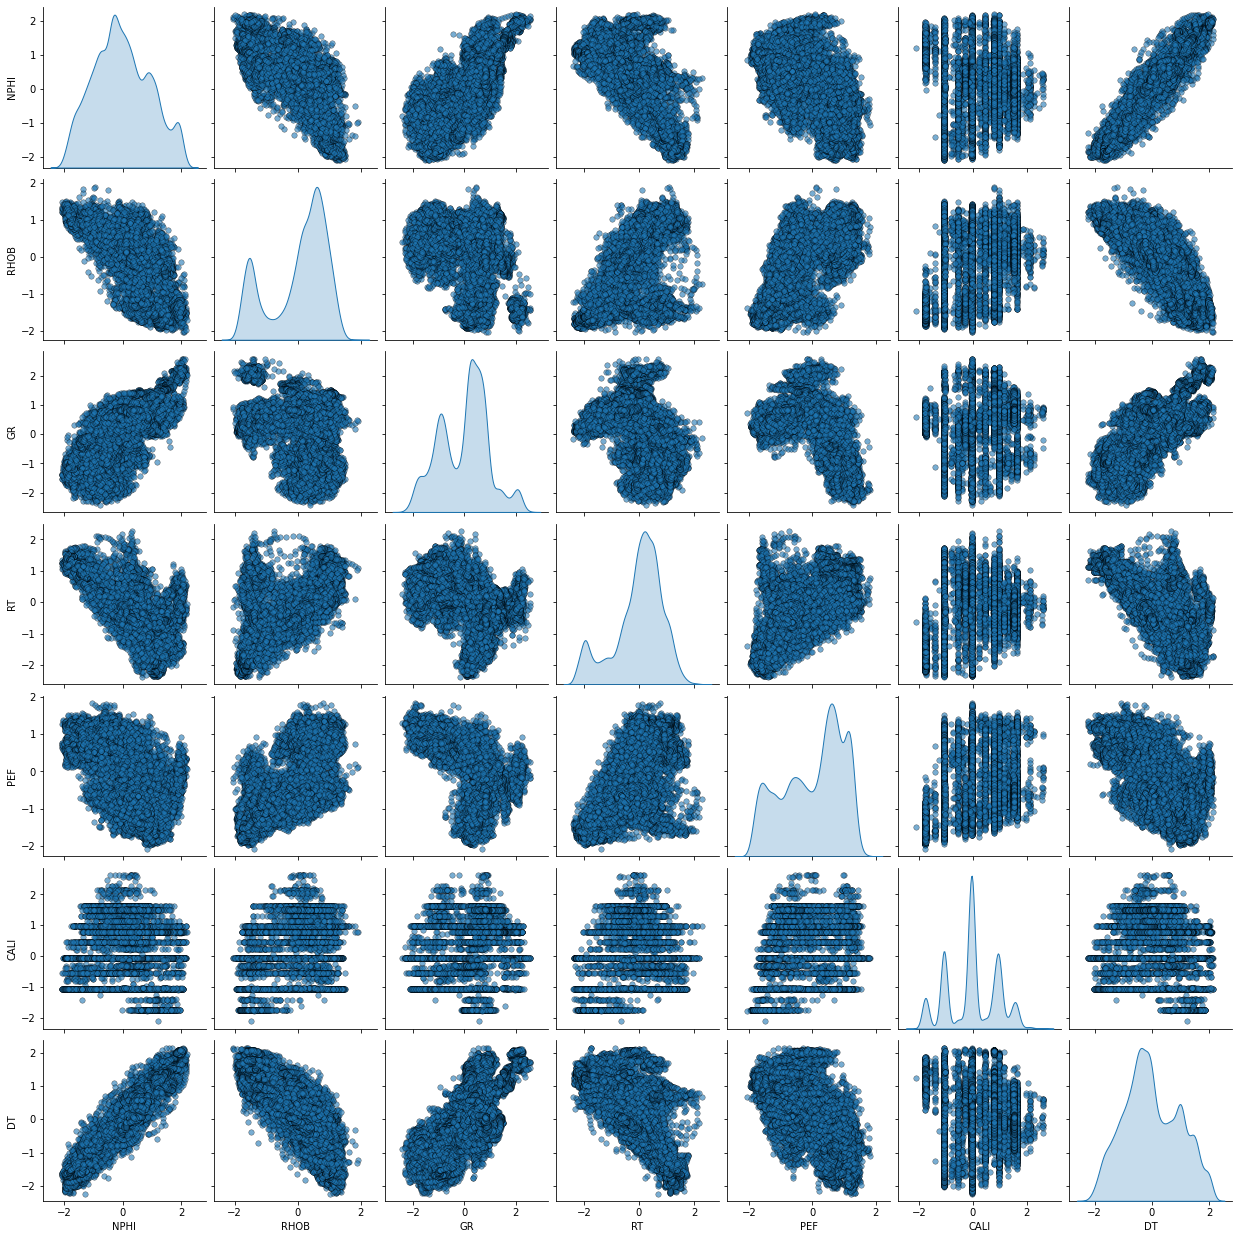

In [37]:
# visualize the pairplot after normalization and outliers removed
import seaborn as sns

sns.pairplot(well_train_svm, vars=feature_target,
             diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

Then, load the prediction (test) data. Note that this data also hasn't been normalized.

In [8]:
# Load test data
well_pred = pd.read_csv('/content/volve-machine-learning/results/wells_for_prediction_demo.csv')
well_pred.head(10)

,NPHI,RHOB,GR,RT,PEF,CALI,WELL,DEPTH
0,0.075,2.605,9.348,8.331,7.451,8.547,15_9-F-11B,3200.0
1,0.077,2.602,9.362,8.289,7.464,8.547,15_9-F-11B,3200.1
2,0.078,2.599,9.545,8.247,7.405,8.547,15_9-F-11B,3200.2
3,0.079,2.594,11.153,8.206,7.292,8.547,15_9-F-11B,3200.3
4,0.078,2.589,12.592,8.165,7.167,8.547,15_9-F-11B,3200.4
5,0.075,2.587,12.644,8.401,7.067,8.547,15_9-F-11B,3200.5
6,0.074,2.589,13.029,8.300,7.010,8.547,15_9-F-11B,3200.6
7,0.074,2.594,13.167,8.298,7.000,8.547,15_9-F-11B,3200.7
8,0.075,2.599,13.246,8.301,7.033,8.547,15_9-F-11B,3200.8
9,0.076,2.603,13.015,8.126,7.090,8.547,15_9-F-11B,3200.9


Define the training features `X_train` and training target `y_train`. 

In [38]:
# Define the train data
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names

X_train = well_train_svm[only_feature].values
y_train = well_train_svm[only_target].values

And define the test features `X_test`. Here, we split the prediction data `well_pred` into individual wells; 11B and 1C, as `X_test2` and `X_test5` respectively. Also, we produce the depths (later we use the depths for viewing the logs)

In [39]:
# Define the test data 
names_train = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []
for i in range(len(names_train)):
  # split the df with respect to its name
  test = well_pred.loc[well_pred['WELL'] == names_train[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature)
  X_test_ = test[only_feature].values

  # define depth
  depth_ = test['DEPTH'].values
  
  X_test.append(X_test_)
  depths.append(depth_)

# for each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

We do the prediction by first fitting the training data with a regressor. The regressor used is Gradient Boosting, and its hyperparameter has been tuned (see the original notebook). 

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the regressor with already tuned hyperparams
model = GradientBoostingRegressor(max_depth=10, n_estimators=1000)

# Fit the regressor to the training data
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

We have finished the fitting. Now we should normalize our test sets (because it hasn't been normalized), using the `scaler` that we have loaded from the `.sav` file before.

In [41]:
# Normalize X_test of well 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

Then, predict on the normalized test sets!

In [42]:
# Predict to well 2 and 5
y_pred2 = model.predict(X_test2)
y_pred5 = model.predict(X_test5)

We have now obtained the prediction result (as DT logs). But, the prediction result is still in a normalized form. We need to de-normalize it back.

In [44]:
# Denormalize y_pred of well 2 and 5
# make the transformer fit to the target
y = well_train[only_target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1,1))
y_pred5 = scaler.inverse_transform(y_pred5.reshape(-1,1))

Finally we plot the predicted DT log result both for well 11B and 1C.

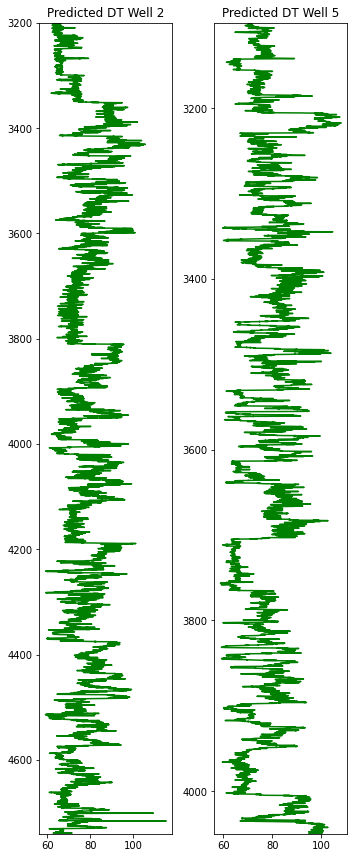

In [46]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(y_pred2, depth2, color='green')
plt.ylim(max(depth2), min(depth2))
plt.title('Predicted DT Well 2', size=12)

plt.subplot(1,2,2)
plt.plot(y_pred5, depth5, color='green')
plt.ylim(max(depth5), min(depth5))
plt.title('Predicted DT Well 5', size=12)

plt.tight_layout(1)
plt.show()